In [59]:
import pandas as pd
import numpy as np
import itertools, csv

massWidth = 30 #GeV

4605 rows of dihiggs data
1703 rows of qcd data
Index(['hh_mass', 'h1_mass', 'h2_mass', 'deltaR(h1, h2)', 'deltaR(h1 jets)',
       'deltaR(h2 jets)'],
      dtype='object') hh_mass


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7199a869e8>]],
      dtype=object)

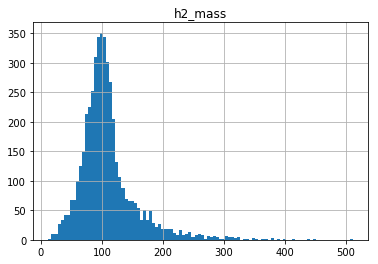

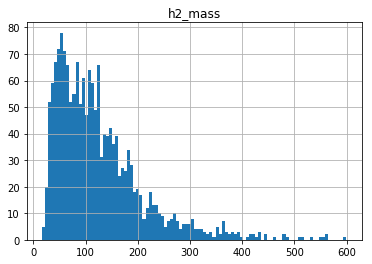

In [60]:
# *** 0. Import Dataset
qcd_raw = pd.read_csv('../higgsReconstruction/EventPlotting/qcd_outputDataForLearning.csv')
hh_raw = pd.read_csv('../higgsReconstruction/EventPlotting/dihiggs_outputDataForLearning.csv')

hh_raw.head()
print(len(hh_raw), "rows of dihiggs data")
#print(hh_raw.columns)
qcd_raw.head()
print(len(qcd_raw), "rows of qcd data")

#variableNames = ['hh_mass', 'h1_mass', 'h2_mass']
#variableNames = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']
variableNames = ['hh_mass', 'h1_mass', 'h2_mass', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']

hh_reducedData  = hh_raw[variableNames]
qcd_reducedData = qcd_raw[variableNames]
print(hh_reducedData.columns, variableNames[0])
hh_reducedData.hist(column=variableNames[2], bins=100)
qcd_reducedData.hist(column=variableNames[2], bins=100)


In [69]:
def returnCutValueByConstantEfficiency( _variable, _signal, _background, _eff, _inequality = '>'):
    """return a cut value based on keeping some constant efficiency of signal"""

    _bestCutValue = -1
    _nTotalSignal =len(_signal) 
    _nTotalBackground =len(_background) 
    _cuts = []
    
    _minVal = int(min(min(_background), min(_signal))) if 'mass' not in _variable else int(min(min(_background), min(_signal))) - int(min(min(_background), min(_signal)))%5
    _maxVal = int(max(max(_background), max(_signal))) if 'mass' not in _variable else int(max(max(_background), max(_signal))) - int(max(max(_background), max(_signal)))%5
    if 'mass' in _variable:
        #_cuts = list(range(_minVal, _maxVal, _stepSize))
        _cuts = list(range(0, _maxVal, 5))
        #print(_maxVal, max(_background), max(_signal))
    elif 'deltaR' in _variable:
        #_cuts = np.linspace(_minVal, _maxVal, 100)
        _cuts = np.linspace(0, 5, 101)


    for iCutValue in _cuts:
        if _inequality == '<':
            _nSignal = sum( value < iCutValue for value in _signal)
            _nBackground = sum( value < iCutValue for value in _background)
        elif _inequality == '>':
            _nSignal = sum( value > iCutValue for value in _signal)
            _nBackground = sum( value > iCutValue for value in _background)
        else:
            print("Unknown inequality operator {0}. EXITING".format(_inequality))
            return _bestCutValue, _nTotalSignal, _nTotalBackground
        
        # safety check to avoid division by 0
        if _nBackground == 0:
            continue
        
        if _inequality == '<':
            if _nSignal / _nTotalSignal >= _eff:
                _bestCutValue = iCutValue
                return _bestCutValue, _nSignal, _nBackground
        elif _inequality== '>':
            if _nSignal / _nTotalSignal < _eff: # passed threshold so return previous cut
                _nSignalBest = sum( value > _bestCutValue for value in _signal)
                _nBackgroundBest = sum( value > _bestCutValue for value in _background)
                return _bestCutValue, _nSignalBest, _nBackgroundBest
            else:
                _bestCutValue = iCutValue
            
    return _bestCutValue, -1, -1
    
    
def returnBestCutValue( _variable, _signal, _background, _method='S/B'):
    """find best cut according to user-specified significance metric"""
    
    _bestSignificance = -1
    _bestCutValue = -1
    _massWidth = massWidth #GeV
    _nTotalSignal =len(_signal) 
    _nTotalBackground =len(_background) 
    _cuts = []
    
    _minVal = int(min(min(sortedBackground), min(sortedSignal))) if 'mass' not in _variable else int(min(min(sortedBackground), min(sortedSignal))) - int(min(min(sortedBackground), min(sortedSignal)))%5
    _maxVal = int(max(max(sortedBackground), max(sortedSignal))) if 'mass' not in _variable else int(max(max(sortedBackground), max(sortedSignal))) - int(max(max(sortedBackground), max(sortedSignal)))%5
    if 'mass' in _variable:
        _stepSize = 0.05 if 'mass' not in _variable else 5
        _cuts = list(range(_minVal, _maxVal, _stepSize))
    else:
        _cuts = np.linspace(_minVal, _maxVal, 100)
    
    for iCutValue in _cuts:
        if 'mass' in _variable:
            _nSignal = sum( (value > iCutValue and value < (iCutValue+_massWidth)) for value in _signal) 
            _nBackground = sum( (value > iCutValue and value < (iCutValue+_massWidth)) for value in _background)
        else:
            _nSignal = sum( value < iCutValue for value in _signal)
            _nBackground = sum( value < iCutValue for value in _background)

        # temporary fix since samples with different number of events
        #_nSignal = _nSignal / _nTotalSignal
        #_nBackground = _nBackground / _nTotalBackground
        _nSignal = _nSignal * (_nTotalBackground / _nTotalSignal )
        #_nBackground = _nBackground / _nTotalBackground
        
        # safety check to avoid division by 0
        if _nBackground == 0:
            continue
        
        #if _method == 'S/sqrt(S+B)':
        #    print(_nSignal, _nBackground, iCutValue, (_nSignal / np.sqrt(_nSignal + _nBackground)))
        
        if _method == 'S/B' and (_nSignal / _nBackground) > _bestSignificance:
            _bestSignificance = (_nSignal / _nBackground)
            _bestCutValue = iCutValue
        elif _method == 'S/sqrt(B)' and (_nSignal / np.sqrt(_nBackground)) > _bestSignificance:
            _bestSignificance = (_nSignal / np.sqrt(_nBackground))
            _bestCutValue = iCutValue
        elif _method == 'S/sqrt(S+B)' and (_nSignal / np.sqrt(_nSignal + _nBackground)) > _bestSignificance:
            _bestSignificance = (_nSignal / np.sqrt(_nSignal + _nBackground))
            _bestCutValue = iCutValue
        
    return _bestSignificance, _bestCutValue


def returnSignificanceOrderedCutDict( _method, _varNames, _signalDataFrame, _backgroundDataFrame):
    """function to return list of cuts ordered by descending significance"""
    
    _orderedVariableAndCutDict = {}
    _unprocessedVariables = _varNames
    _signalAfterCuts = _signalDataFrame
    _backgroundAfterCuts = _backgroundDataFrame
    
    while len(_unprocessedVariables)>0:
        _iBestCut = -1
        _iBestSignificance = -1
        _iBestVariable = ''
        print('iteration {0}, signal has {1} rows'.format(len(_unprocessedVariables), len(_signalAfterCuts)))
        print('iteration {0}, background has {1} rows'.format(len(_unprocessedVariables), len(_backgroundAfterCuts)))
        
        for iVariable in _unprocessedVariables:
            _sortedSignal = np.sort(_signalDataFrame[iVariable].values)
            _sortedBackground = np.sort(_backgroundDataFrame[iVariable].values)
            #print(_sortedSignal)
            _tempSignificance, _tempCut = returnBestCutValue( iVariable, _sortedSignal, _sortedBackground, _method)
            #print ( iVariable, _tempSignificance, _tempCut )
                
            # most significant 1D variable so far in this iteration
            if _tempSignificance > _iBestSignificance:
                _iBestSignificance = _tempSignificance
                _iBestCut = _tempCut
                _iBestVariable = iVariable
        
        print('Iteration {0} chose variable {1} with significance {2} at cut {3}'.format(int(len(_varNames)-len(_unprocessedVariables)), _iBestVariable, _iBestSignificance, _iBestCut))
        _unprocessedVariables.remove(_iBestVariable)
        _orderedVariableAndCutDict[_iBestVariable] = [_iBestCut, _iBestSignificance]
        if 'mass' in _iBestVariable:
            _signalAfterCuts = _signalAfterCuts[ (_signalAfterCuts[_iBestVariable] > _iBestCut) & (_signalAfterCuts[_iBestVariable]< (_iBestCut + massWidth))]
            _backgroundAfterCuts = _backgroundAfterCuts[ (_backgroundAfterCuts[_iBestVariable] > _iBestCut) & (_backgroundAfterCuts[_iBestVariable]< (_iBestCut + massWidth))]
        else:
            _signalAfterCuts = _signalAfterCuts[ _signalAfterCuts[_iBestVariable] < _iBestCut ]
            _backgroundAfterCuts = _backgroundAfterCuts[ _backgroundAfterCuts[_iBestVariable] < _iBestCut ]
            
    return _orderedVariableAndCutDict

In [8]:
for iColumn in range(0, len(hh_reducedData.columns) ):
    varName = variableNames[iColumn]
    sortedSignal = np.sort(hh_reducedData[varName].values)
    sortedBackground = np.sort(qcd_reducedData[varName].values)
    
    bestCut, significance = returnBestCutValue( varName, sortedSignal, sortedBackground, 'S/B')
    print ( varName, bestCut, significance )
    bestCut, significance = returnBestCutValue( varName, sortedSignal, sortedBackground, 'S/sqrt(B)')
    print ( varName, bestCut, significance )
    bestCut, significance = returnBestCutValue( varName, sortedSignal, sortedBackground, 'S/sqrt(S+B)')
    print ( varName, bestCut, significance )
    
print("=====================================")
    

deltaR(h1, h2) 3.6981541802388707 0.2828282828282828
deltaR(h1, h2) 44.24970291081079 3.323232323232323
deltaR(h1, h2) 29.482700944781083 3.818181818181818
deltaR(h1 jets) 1.5422089772911034 1.9696969696969697
deltaR(h1 jets) 43.241146858604495 2.5757575757575757
deltaR(h1 jets) 29.601200756726165 3.2323232323232323
deltaR(h2 jets) 1.1937424155329883 2.5757575757575757
deltaR(h2 jets) 42.825355396766525 3.3333333333333335
deltaR(h2 jets) 29.48199235448601 3.4343434343434343


In [9]:
orderedCuts_SoverB = returnSignificanceOrderedCutDict( 'S/B', variableNames.copy(), hh_reducedData.copy(), qcd_reducedData.copy())
print (orderedCuts_SoverB)
orderedCuts_SoverSqrtB = returnSignificanceOrderedCutDict( 'S/sqrt(B)', variableNames.copy(), hh_reducedData.copy(), qcd_reducedData.copy())
print (orderedCuts_SoverSqrtB)
orderedCuts_SoverSqrtSB = returnSignificanceOrderedCutDict( 'S/sqrt(S+B)', variableNames.copy(), hh_reducedData.copy(), qcd_reducedData.copy())
print (orderedCuts_SoverSqrtSB)

iteration 3, signal has 4605 rows
iteration 3, background has 1703 rows
Iteration 0 chose variable deltaR(h1, h2) with significance 3.205066956207021 at cut 0.45454545454545453
iteration 2, signal has 26 rows
iteration 2, background has 3 rows
Iteration 0 chose variable deltaR(h1 jets) with significance 1.5422089772911034 at cut 1.9696969696969697
iteration 1, signal has 17 rows
iteration 1, background has 2 rows
Iteration 0 chose variable deltaR(h2 jets) with significance 1.1937424155329883 at cut 2.5757575757575757
{'deltaR(h1, h2)': [0.45454545454545453, 3.205066956207021], 'deltaR(h1 jets)': [1.9696969696969697, 1.5422089772911034], 'deltaR(h2 jets)': [2.5757575757575757, 1.1937424155329883]}
iteration 3, signal has 4605 rows
iteration 3, background has 1703 rows
Iteration 0 chose variable deltaR(h1, h2) with significance 44.33513291962043 at cut 3.282828282828283
iteration 2, signal has 3881 rows
iteration 2, background has 1048 rows
Iteration 0 chose variable deltaR(h1 jets) with

In [72]:
def getCutsForSpecifiedEfficiency( _signal, _background, _eff, _inequality = '<'):
    """get cuts for all variables given user-specified efficency"""

    print("========== Efficiency {0}% , Using {1} =========".format(_eff, _inequality) )
    for iColumn in range(0, len(_signal.columns) ):
        varName = variableNames[iColumn]
        sortedSignal = np.sort(_signal[varName].values)
        sortedBackground = np.sort(_background[varName].values)
    
        cutVal, nSig, nBkg = returnCutValueByConstantEfficiency( varName, sortedSignal, sortedBackground, _eff, _inequality)
        print('Cut of {4} {0} on {1} yields nSig = {2} and nBkg = {3}'.format(round(cutVal,2), varName, nSig, nBkg, _inequality))    
    

In [73]:
getCutsForSpecifiedEfficiency(hh_reducedData, qcd_reducedData, 0.80, '<')
getCutsForSpecifiedEfficiency(hh_reducedData, qcd_reducedData, 0.85, '<')
getCutsForSpecifiedEfficiency(hh_reducedData, qcd_reducedData, 0.90, '<')

getCutsForSpecifiedEfficiency(hh_reducedData, qcd_reducedData, 0.80, '>')
getCutsForSpecifiedEfficiency(hh_reducedData, qcd_reducedData, 0.85, '>')
getCutsForSpecifiedEfficiency(hh_reducedData, qcd_reducedData, 0.90, '>')

========== Efficiency 0.8% , Using < =========
Cut of < 485 on hh_mass yields nSig = 3715 and nBkg = 1089
Cut of < 140 on h1_mass yields nSig = 3706 and nBkg = 905
Cut of < 130 on h2_mass yields nSig = 3687 and nBkg = 1076
Cut of < 3.25 on deltaR(h1, h2) yields nSig = 3797 and nBkg = 1012
Cut of < 2.6 on deltaR(h1 jets) yields nSig = 3709 and nBkg = 1007
Cut of < 2.75 on deltaR(h2 jets) yields nSig = 3749 and nBkg = 1183
========== Efficiency 0.85% , Using < =========
Cut of < 525 on hh_mass yields nSig = 3935 and nBkg = 1207
Cut of < 155 on h1_mass yields nSig = 3930 and nBkg = 1044
Cut of < 145 on h2_mass yields nSig = 3917 and nBkg = 1171
Cut of < 3.35 on deltaR(h1, h2) yields nSig = 3992 and nBkg = 1125
Cut of < 2.8 on deltaR(h1 jets) yields nSig = 3956 and nBkg = 1145
Cut of < 2.9 on deltaR(h2 jets) yields nSig = 3975 and nBkg = 1273
========== Efficiency 0.9% , Using < =========
Cut of < 575 on hh_mass yields nSig = 4154 and nBkg = 1303
Cut of < 175 on h1_mass yields nSig = 4145 